In [ ]:
import torch
from torch_geometric.datasets import TUDataset

dataset=TUDataset(root="data/TUDataset",name="MUTAG")

print(dataset)

MUTAG(188)


In [8]:
print(len(dataset))
print(dataset.num_features)
print(dataset.num_classes)


188
7
2


In [11]:
data=dataset[1]
print()
print(data)
print("*"*30)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])
******************************
Number of nodes: 13
Number of edges: 28
Average node degree: 2.15
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [12]:
print(data.x)
print(data.edge_attr)
print(data.y)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1.

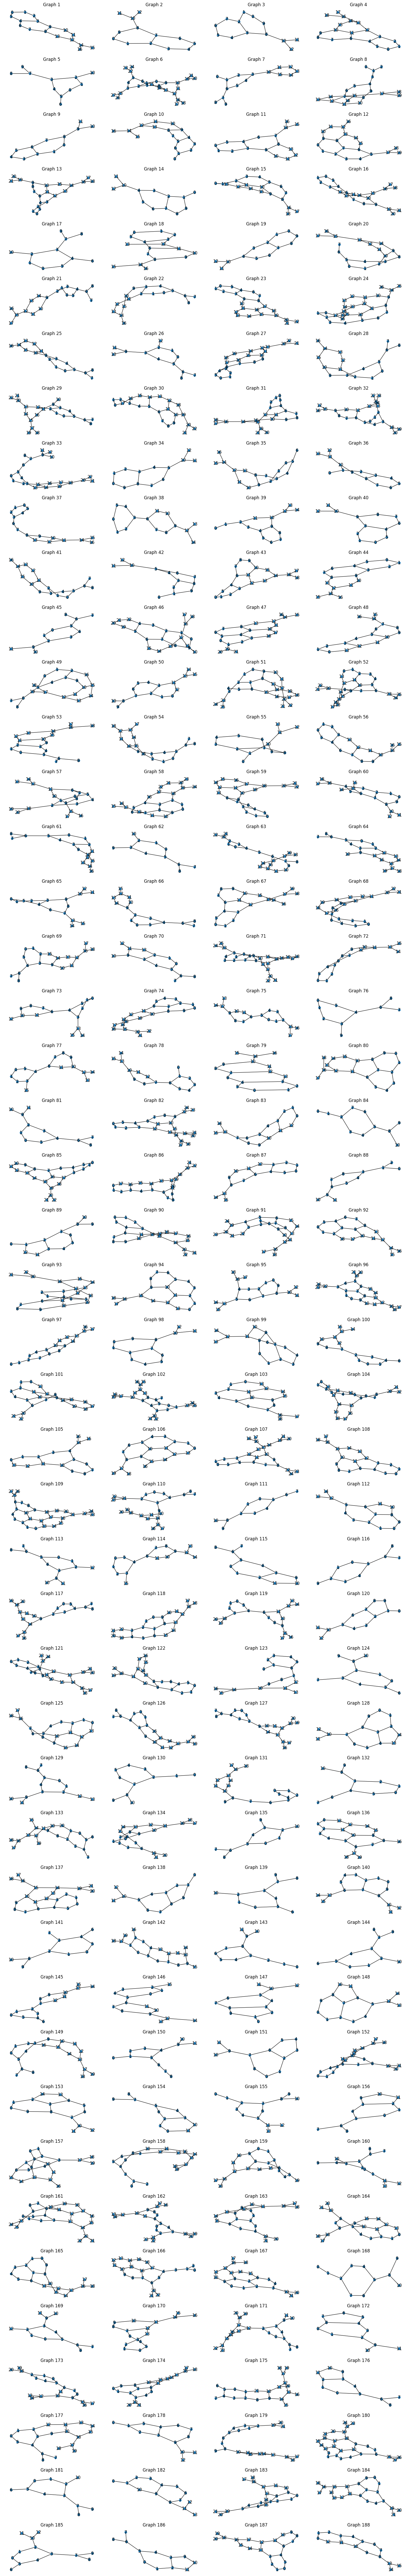

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

fig,axes=plt.subplots(nrows=47,ncols=4,figsize=(16,100))

for i,data in enumerate(dataset):
    row,col=divmod(i,4)

    G=nx.Graph()

    G.add_nodes_from(range(data.x.shape[0]))

    edge_index=data.edge_index.numpy()
    G.add_edges_from(edge_index.T)

    pos=nx.spring_layout(G)
    nx.draw(G,pos,ax=axes[row,col],with_labels=True,node_size=40)
    axes[row, col].set_title(f'Graph {i+1}')

plt.tight_layout()
plt.show()


In [17]:
dataset=dataset.shuffle()

train_dataset=dataset[:150]
test_dataset=dataset[150:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [22]:
def visualize(data):
    G=nx.Graph()

    edge_index=data.edge_index.numpy()
    G.add_edges_from(edge_index.T)

    pos=nx.spring_layout(G)
    nx.draw(G,pos,font_weight="bold",node_size=10,node_color="skyblue",font_size=8)

    plt.figure(figsize=(600,200))
    plt.tight_layout()
    plt.show()
    

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2446], x=[1110, 7], edge_attr=[2446, 4], y=[64], batch=[1110], ptr=[65])



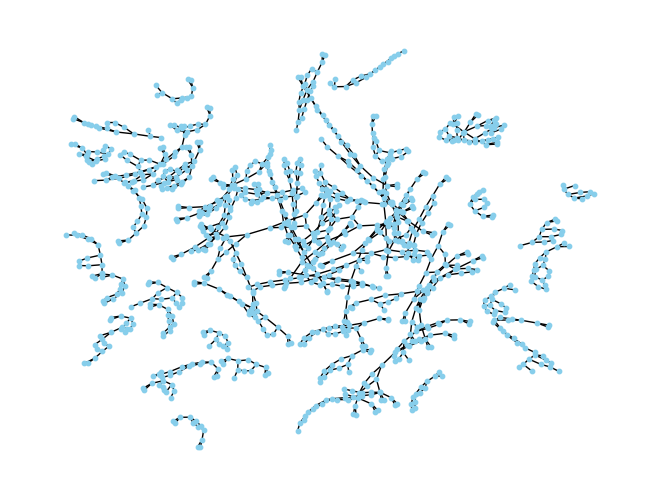

<Figure size 60000x20000 with 0 Axes>

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2620], x=[1183, 7], edge_attr=[2620, 4], y=[64], batch=[1183], ptr=[65])



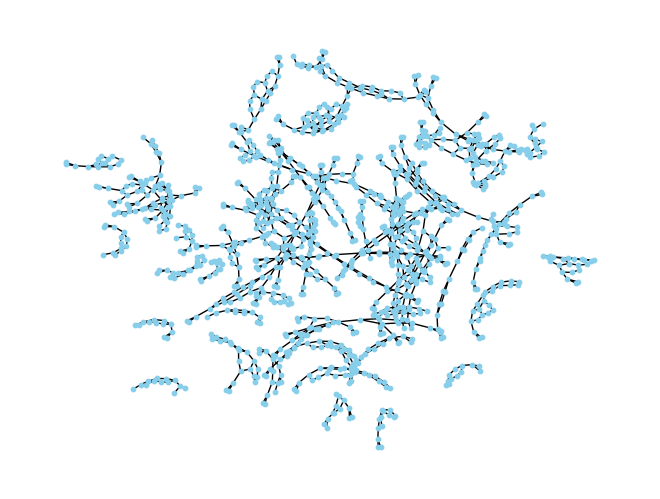

<Figure size 60000x20000 with 0 Axes>

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 914], x=[410, 7], edge_attr=[914, 4], y=[22], batch=[410], ptr=[23])



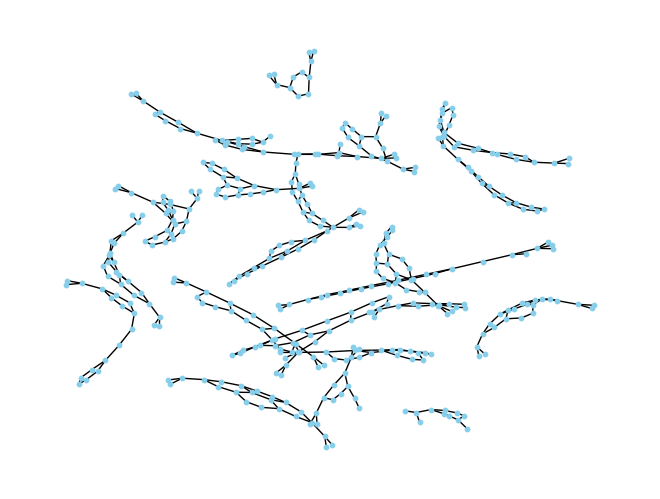

<Figure size 60000x20000 with 0 Axes>

In [23]:
from torch_geometric.loader import DataLoader

train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=64,shuffle=True)

for step,data in enumerate(train_dataloader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

    visualize(data)



In [31]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

class GATV2(nn.Module):
    def __init__(self,output_channels=2):
        super(GATV2,self).__init__()
        self.conv1=GATv2Conv(dataset.num_node_features,64,heads=4,concat=False)
        self.conv2=GATv2Conv(64,32,heads=2,concat=False)

        self.classifier=nn.Linear(32,output_channels)

    def forward(self,x,edge_index,batch):
        x=F.relu(self.conv1(x,edge_index))
        x=F.relu(self.conv2(x,edge_index))

        x=global_mean_pool(x,batch)

        x=F.dropout(x,p=0.4,training=self.training)

        x=self.classifier(x)

        return x
    
model=GATV2()
print(model)

total_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = model.to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss(reduction='sum') 
data = data.to(device)

start_time = time.time()

def train():
    model.train()
    train_loss=0.0

    for data in train_dataloader:
        data=data.to(device)
        optimizer.zero_grad()
        outputs=model(data.x, data.edge_index, data.batch)
        loss=criterion(outputs,data.y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss *1.0/len(train_dataset)

def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data=data.to(device)
        outputs = model(data.x, data.edge_index, data.batch)
        preds = outputs.argmax(dim=1)
        correct += int((preds == data.y).sum())

    return correct / len(loader.dataset)


for epoch in range(201):
    loss=train()
    train_acc=test(train_dataloader)
    test_acc=test(test_dataloader)
    if epoch % 20 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'.format(epoch, loss, train_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


GATV2(
  (conv1): GATv2Conv(7, 64, heads=4)
  (conv2): GATv2Conv(64, 32, heads=2)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)
Total parameters: 12898
Epoch #000, Loss: 0.6885, Train_Accuracy: 0.6733, Test_Accuracy: 0.6316
Epoch #020, Loss: 0.5271, Train_Accuracy: 0.7467, Test_Accuracy: 0.7895
Epoch #040, Loss: 0.5199, Train_Accuracy: 0.7600, Test_Accuracy: 0.8421
Epoch #060, Loss: 0.5099, Train_Accuracy: 0.7667, Test_Accuracy: 0.8158
Epoch #080, Loss: 0.4877, Train_Accuracy: 0.7467, Test_Accuracy: 0.8158
Epoch #100, Loss: 0.5042, Train_Accuracy: 0.7667, Test_Accuracy: 0.8158
Epoch #120, Loss: 0.5140, Train_Accuracy: 0.7400, Test_Accuracy: 0.8158
Epoch #140, Loss: 0.4848, Train_Accuracy: 0.7533, Test_Accuracy: 0.8421
Epoch #160, Loss: 0.4976, Train_Accuracy: 0.7667, Test_Accuracy: 0.8421
Epoch #180, Loss: 0.4989, Train_Accuracy: 0.7533, Test_Accuracy: 0.8158
Epoch #200, Loss: 0.4866, Train_Accuracy: 0.7600, Test_Accuracy: 0.8158
Elapsed time: 25.60114288330078 se